In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define paths

In [2]:
train_dir = 'split_data/train'
val_dir = 'split_data/val'
test_dir = 'split_data/test'

# Parameters

In [3]:
img_height, img_width = 128, 128
batch_size = 32
seed = 42

# Create ImageDataGenerator instances

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

Found 3161 images belonging to 9 classes.


# Validation data generator

In [6]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

Found 558 images belonging to 9 classes.


# Test data generator

In [7]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed
)

Found 657 images belonging to 9 classes.


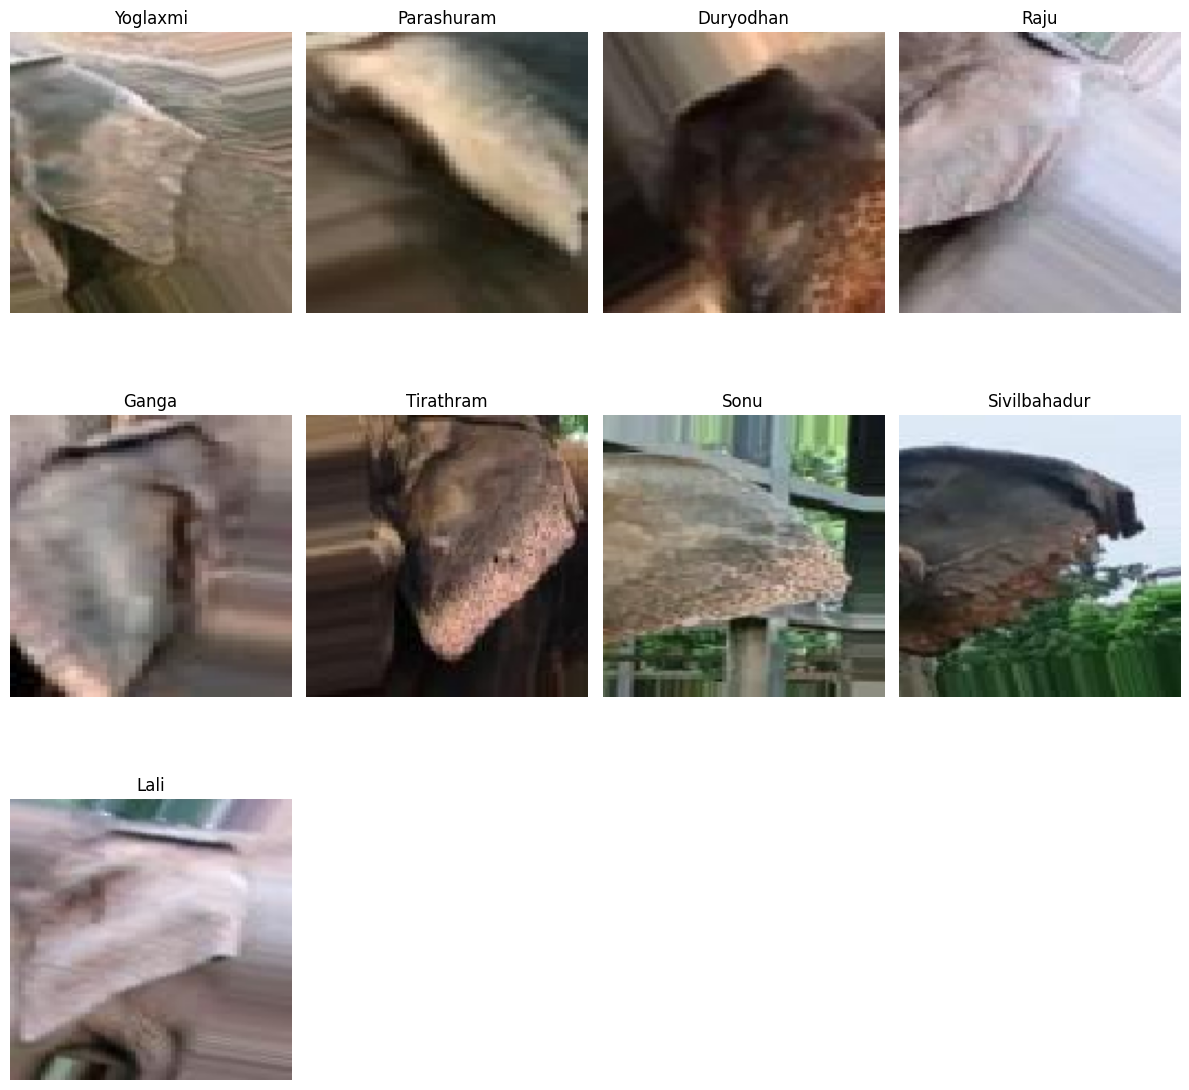

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract class indices and names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Dictionary to keep track of displayed classes
displayed_classes = set()

# Initialize figure
plt.figure(figsize=(12, 12))
subplot_idx = 1

# Loop through test data until all classes are displayed
for image_batch, label_batch in test_generator:
    for img, label in zip(image_batch, label_batch):
        class_idx = np.argmax(label)  # Determine the class index
        if class_idx not in displayed_classes:
            # Scale pixel values back to [0, 255] for visualization
            img = (img * 255).astype("uint8")

            # Display image
            ax = plt.subplot(3, 4, subplot_idx)
            plt.imshow(img)
            plt.title(class_names[class_idx])
            plt.axis("off")
            
            # Add class to displayed classes
            displayed_classes.add(class_idx)
            subplot_idx += 1
            
            # Break if all 9 classes are displayed
            if len(displayed_classes) == len(class_names):
                break
    if len(displayed_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()


# Define the InceptionV3 model

In [9]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
    weights=None,
    pooling='avg',input_shape = (128,128,3))



In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
output =  tf.keras.layers.Dense(len(class_indices), activation='softmax')(base_model.output)
new_model = tf.keras.Model(base_model.input, output)

# Define early stopping

In [19]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

# Compile the model

In [20]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy"), metrics=['accuracy'])

# Train the model

In [22]:
history = new_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[es_callback]
)


Epoch 1/20
99/99 [==============================] - 190s 2s/step - loss: 2.1970 - accuracy: 0.1016 - val_loss: 2.1964 - val_accuracy: 0.1111
Epoch 2/20
99/99 [==============================] - 161s 2s/step - loss: 2.1962 - accuracy: 0.1085 - val_loss: 2.1957 - val_accuracy: 0.1111
Epoch 3/20
99/99 [==============================] - 180s 2s/step - loss: 2.1955 - accuracy: 0.1120 - val_loss: 2.1950 - val_accuracy: 0.1111
Epoch 4/20
99/99 [==============================] - 179s 2s/step - loss: 2.1949 - accuracy: 0.1161 - val_loss: 2.1944 - val_accuracy: 0.1111
Epoch 5/20
99/99 [==============================] - 181s 2s/step - loss: 2.1942 - accuracy: 0.1120 - val_loss: 2.1937 - val_accuracy: 0.1111
Epoch 6/20
99/99 [==============================] - 186s 2s/step - loss: 2.1935 - accuracy: 0.1120 - val_loss: 2.1930 - val_accuracy: 0.1111
Epoch 6: early stopping


# Evaluate the model on the test set

In [13]:
test_loss, test_accuracy = new_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

13/13 [==============================] - 5s 379ms/step - loss: 1.5219 - accuracy: 0.6833
Test Loss: 1.5218958854675293, Test Accuracy: 0.6832917928695679


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true and predicted labels
cnn_y_true = test_generator.classes  # True labels
cnn_y_pred_probs = new_model.predict(test_generator)  # Predicted probabilities
cnn_y_pred = np.argmax(cnn_y_pred_probs, axis=1)  # Predicted classes (indices)

# Step 2: Get class names from the test generator
test_class_names = list(test_generator.class_indices.keys())  # Extract class names from the generator




13/13 [==============================] - 6s 356ms/step


In [15]:
image = 'prediction/g.jpeg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [16]:
predict = new_model.predict(img_bat)

1/1 [==============================] - 1s 702ms/step


In [17]:
score = tf.nn.softmax(predict)

In [18]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

In [19]:
class_names

['Duryodhan',
 'Ganga',
 'Lali',
 'Parashuram',
 'Raju',
 'Sivilbahadur',
 'Sonu',
 'Tirathram',
 'Yoglaxmi']

In [20]:
print('Elephant in image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))

Elephant in image is Sivilbahadur with accuracy of 25.36


In [21]:
new_model.save('alexnet_elephant_model.h5')

Text(0.5, 1.0, 'Training and Validation Loss')

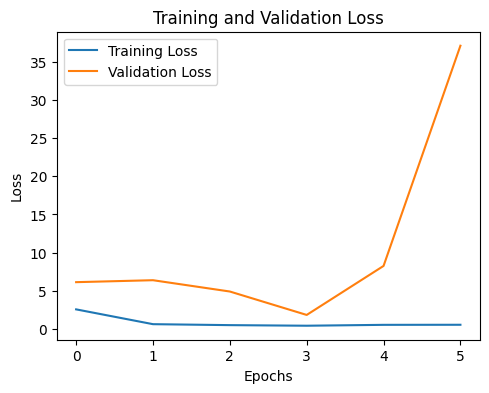

In [22]:

# Training and Validation Loss and Accuracy Graphs
# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss') 


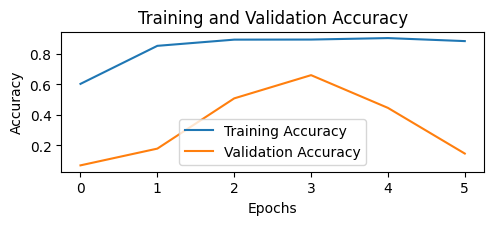

In [23]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


First image to predict:


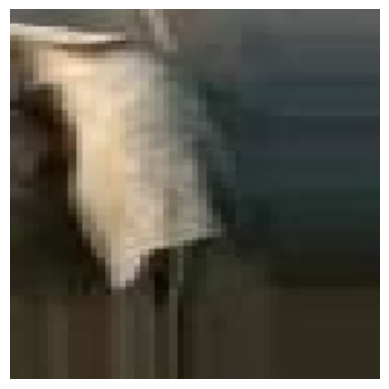

Actual label: Parashuram
1/1 [==============================] - 1s 1s/step
Predicted label: Parashuram


In [24]:
# Fetch one batch of data from the test generator
images_batch, labels_batch = next(test_generator)

# Process the first image and its label
first_image = (images_batch[0] * 255).astype('uint8')  # Rescale to [0, 255] and convert to uint8
first_label = np.argmax(labels_batch[0])              # Get the class index from one-hot encoding

# Display the first image
print("First image to predict:")
plt.imshow(first_image)
plt.axis("off")
plt.show()

# Print actual label
print("Actual label:", class_names[first_label])  # class_names from earlier code

# Make predictions on the batch
batch_prediction = new_model.predict(images_batch)

# Print the predicted label for the first image
predicted_label = np.argmax(batch_prediction[0])
print("Predicted label:", class_names[predicted_label])



1/1 [==============================] - 1s 722ms/step


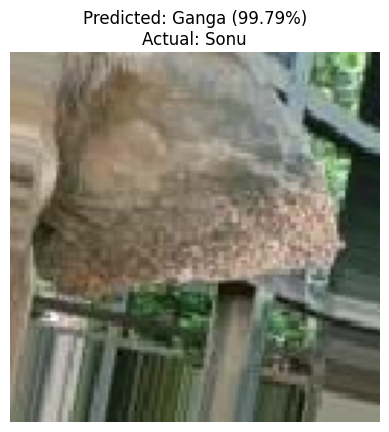

In [25]:
def predict(model, img, class_names):
    """
    Predict the class of a single image using the trained model.

    Args:
        model: Trained Keras model.
        img: A single image in numpy array format.
        class_names: List of class names.

    Returns:
        predicted_class: The predicted class name.
        confidence: The confidence level of the prediction.
    """
    # Preprocess the image
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert to array
    img_array = tf.expand_dims(img_array, 0)  # Create a batch (batch size = 1)

    # Make predictions
    predictions = model.predict(img_array)

    # Determine the predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


# Usage example with test_generator
images_batch, labels_batch = next(test_generator)  # Fetch one batch of test data
test_image = images_batch[0]                       # Select the first image from the batch
actual_label = np.argmax(labels_batch[0])          # Get the true label index

# Predict using the model
predicted_label, confidence = predict(new_model, test_image, class_names)

# Display the image and prediction
plt.imshow((test_image * 255).astype("uint8"))  # Rescale for display
plt.axis("off")
plt.title(f"Predicted: {predicted_label} ({confidence}%)\nActual: {class_names[actual_label]}")
plt.show()


1/1 [==============================] - 0s 111ms/step


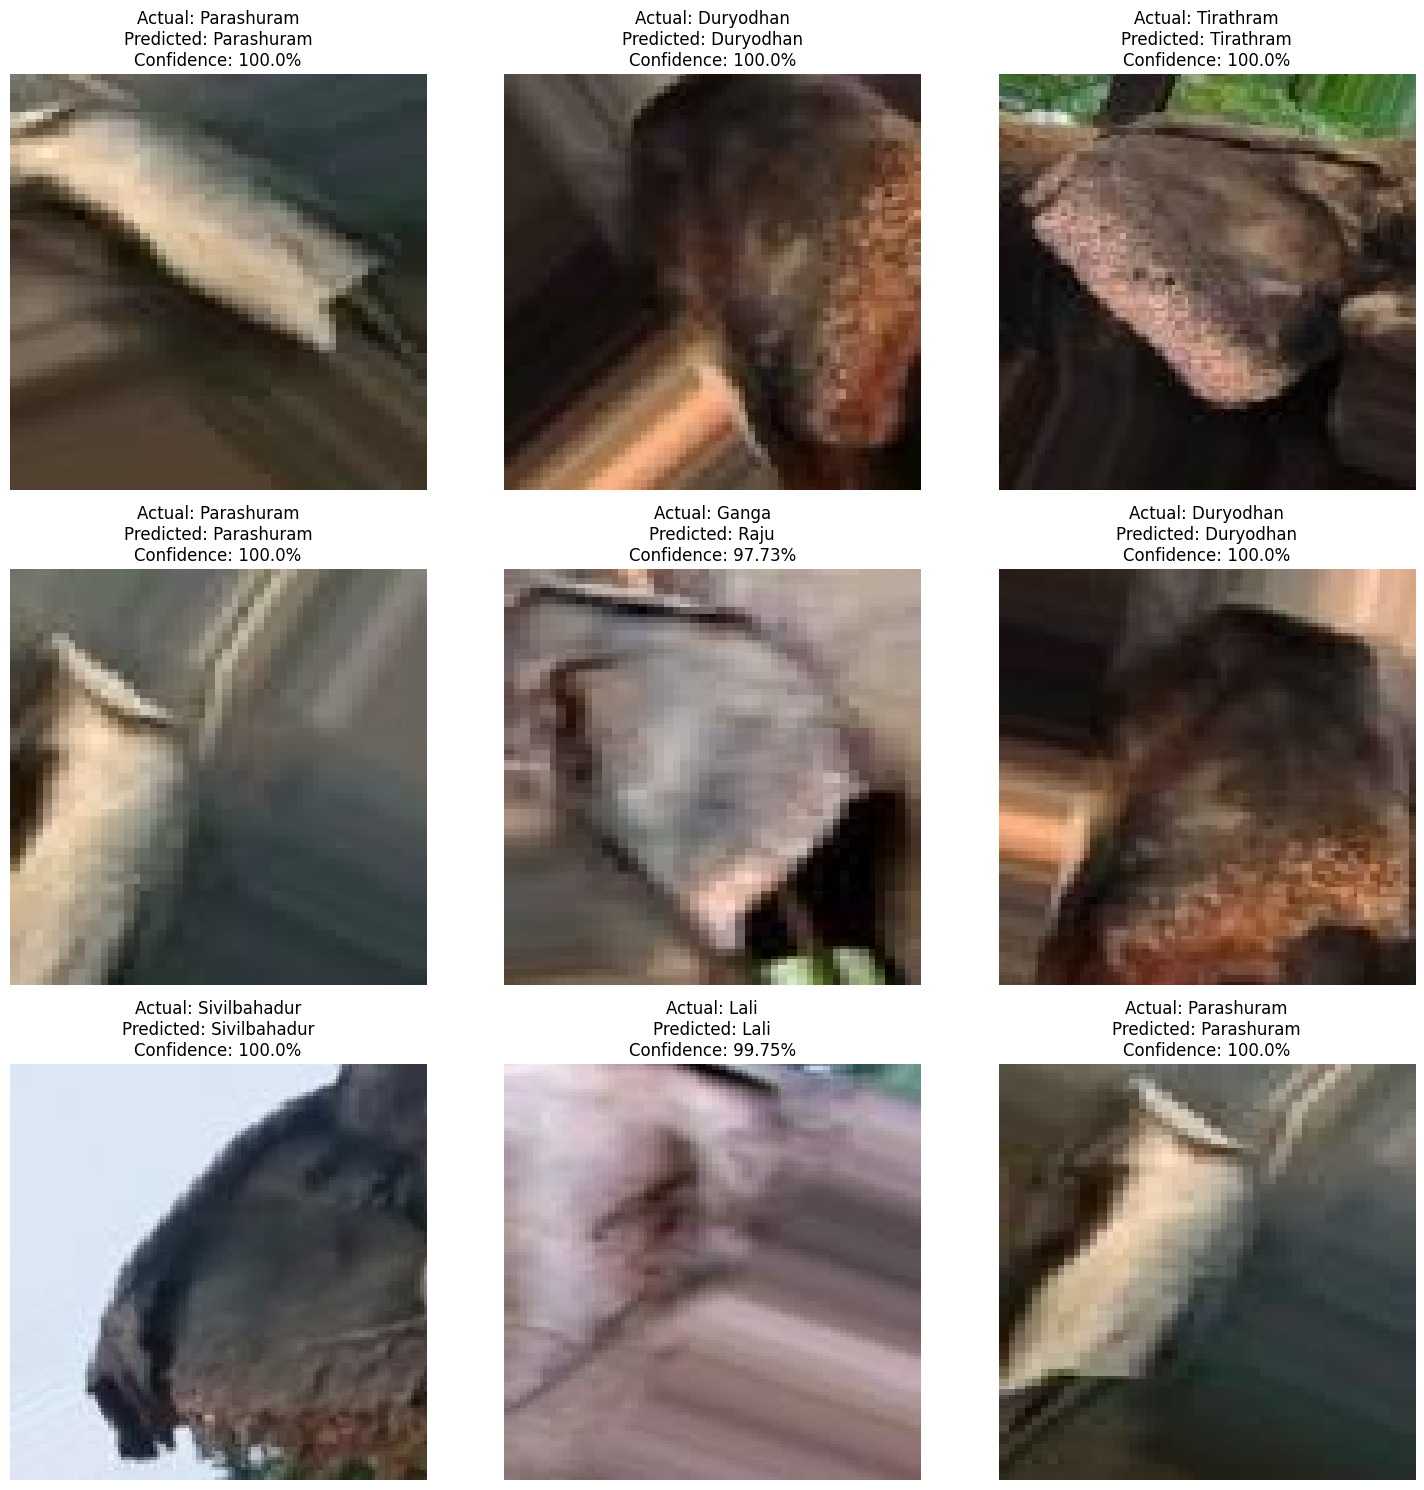

In [26]:
plt.figure(figsize=(15, 15))

# Fetch one batch of data from the test generator
images_batch, labels_batch = next(test_generator)

# Loop through the first 9 images in the batch
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Rescale image for visualization
    image = (images_batch[i] * 255).astype("uint8")
    plt.imshow(image)

    # Predict the class and confidence
    predicted_class, confidence = predict(new_model, images_batch[i], class_names)

    # Get the actual class name
    actual_class = class_names[np.argmax(labels_batch[i])]

    # Set the title with actual and predicted labels
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
    plt.axis("off")

plt.tight_layout()
plt.show()


Confusion Matrix

13/13 [==============================] - 5s 402ms/step
CNN Classification Report:
              precision    recall  f1-score   support

   Duryodhan       0.14      0.14      0.14        44
       Ganga       0.07      0.07      0.07        44
        Lali       0.14      0.25      0.18        44
  Parashuram       0.10      0.09      0.09        45
        Raju       0.11      0.18      0.14        44
Sivilbahadur       0.09      0.11      0.10        45
        Sonu       0.00      0.00      0.00        45
   Tirathram       0.13      0.13      0.13        45
    Yoglaxmi       0.20      0.09      0.12        45

    accuracy                           0.12       401
   macro avg       0.11      0.12      0.11       401
weighted avg       0.11      0.12      0.11       401



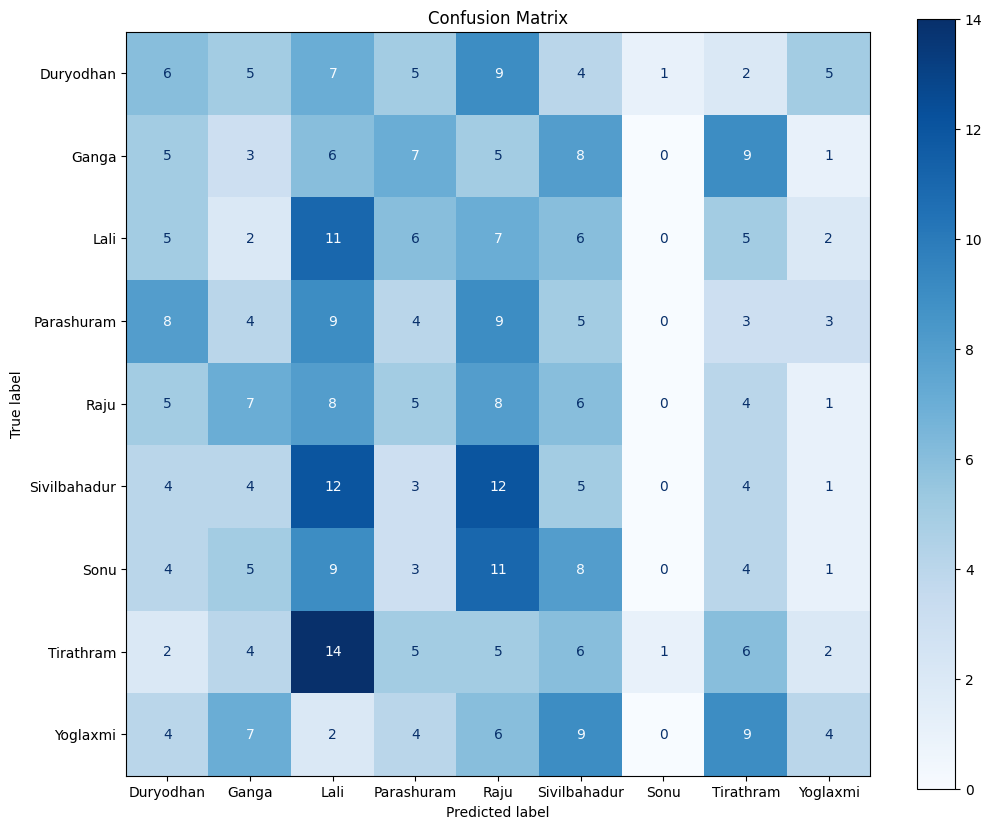

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true and predicted labels
cnn_y_true = test_generator.classes  # True labels
cnn_y_pred_probs = new_model.predict(test_generator)  # Predicted probabilities
cnn_y_pred = np.argmax(cnn_y_pred_probs, axis=1)  # Predicted classes (indices)

# Step 2: Get class names from the test generator
test_class_names = list(test_generator.class_indices.keys())  # Extract class names from the generator

# Step 3: Print the classification report
print("CNN Classification Report:")
print(classification_report(cnn_y_true, cnn_y_pred, target_names=test_class_names))

# Step 4: Compute the confusion matrix
cm = confusion_matrix(cnn_y_true, cnn_y_pred)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()


ROC Curve

13/13 [==============================] - 5s 401ms/step


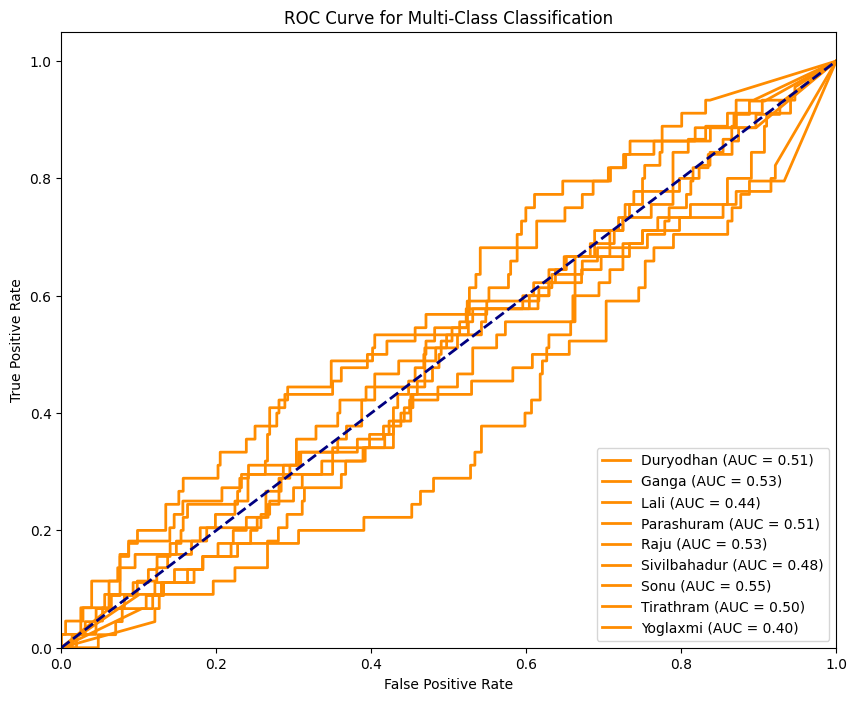

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras import backend as K

# Step 1: Get true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred_probs = new_model.predict(test_generator)  # Predicted probabilities

# Step 2: Binarize the true labels for multi-class ROC curve
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))  # Binarize labels for multi-class

# Step 3: Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Step 5: Plot random chance line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Step 6: Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()
